In [1]:
import torch
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from torch.cuda.amp import autocast
from modules.dvae import GFSQ, DVAEDecoder
from modules.wavenet import WaveNet
import logging
import os
import glob  # 用于查找模型文件
from modules.feature_extractors import MelSpectrogramFeatures

/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
# 设置日志级别为INFO
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.info(f"Use device: {device}")

INFO:root:Use device: mps


加载模型

In [3]:
model_params = {
    "WaveNet": {"input_channels": 100, "output_channels": 1024, 'residual_layers': 20, 'dilation_cycle': 4},
    "GFSQ": {"dim": 1024, "levels": [8, 5, 5, 5], "G": 2, "R": 2},
    "DVAEDecoder": {"idim": 1024, "odim": 100, "n_layer":12, "bn_dim": 128, "hidden":512}
}

In [4]:
wavenet = WaveNet(**model_params["WaveNet"]).to(device)
gfsq = GFSQ(**model_params["GFSQ"]).to(device)
decoder = DVAEDecoder(**model_params["DVAEDecoder"]).to(device)

找到最新的模型并且加载权重

In [5]:
def convert_state_dict_to_float(state_dict):
    """
    将 state_dict 中的所有张量从 fp16 转换为 fp32
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        new_state_dict[k] = v.float()  # 将每个张量转换为float32
    return new_state_dict

In [6]:
checkpoint_files = glob.glob('checkpoint_epoch_*.pth')
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    wavenet.load_state_dict(convert_state_dict_to_float(checkpoint['wavenet_state_dict']))
    gfsq.load_state_dict(convert_state_dict_to_float(checkpoint['gfsq_state_dict']))
    decoder.load_state_dict(convert_state_dict_to_float(checkpoint['decoder_state_dict']))
    start_epoch = checkpoint['epoch']
    logger.info(f"load training from epoch {start_epoch}")
else:
    raise Exception("Not found checkpoint")

INFO:root:load training from epoch 58


# 准备数据并且转换成Mel频谱图

In [7]:
n_fft = 1024
hop_length = 256
win_length = None
sample_rate = 24000
n_mels = 100

In [17]:
import torchaudio


def load_mel_spectrogram(file_path, sample_rate=24000, n_mels=100, n_fft=1024, hop_length=256):
    mel_spectrogram = MelSpectrogramFeatures(
        sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    # 加载音频文件并转换为Mel谱图
    waveform, sr = torchaudio.load(file_path)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    mel_spectrogram = mel_spectrogram(waveform)
    return mel_spectrogram

In [18]:
file_path = '/private/tmp/three_moon/side2_lc1_mar7th_224.wav'
mel_spectrogram = load_mel_spectrogram(
    file_path, sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length).to(device)
print(mel_spectrogram.shape)

torch.Size([100, 1333])


使用模型进行预测

In [19]:
wavenet.eval()
gfsq.eval()
decoder.eval()


DVAEDecoder(
  (conv_in): Sequential(
    (0): Conv1d(1024, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(128, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (decoder_block): ModuleList(
    (0-11): 12 x ConvNeXtBlock(
      (dwconv): Conv1d(512, 512, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,), groups=512)
      (norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (pwconv1): Linear(in_features=512, out_features=2048, bias=True)
      (act): GELU(approximate='none')
      (pwconv2): Linear(in_features=2048, out_features=512, bias=True)
    )
  )
  (conv_out): Conv1d(512, 100, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
)

In [20]:
with torch.no_grad(), autocast():
    features = wavenet(mel_spectrogram[None])
    _, quantized_features, _, _, quantized_indices = gfsq(features)
    decoded_features = decoder(quantized_features)
print(f"origin shape: {mel_spectrogram.shape}")
print(f"decode shape: {decoded_features.shape}")

origin shape: torch.Size([100, 1333])
decode shape: torch.Size([1, 100, 1333])


## 打印二者的Mel频谱图

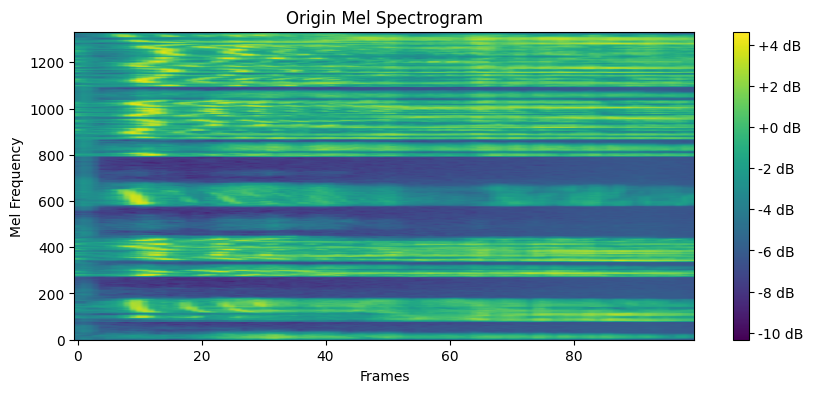

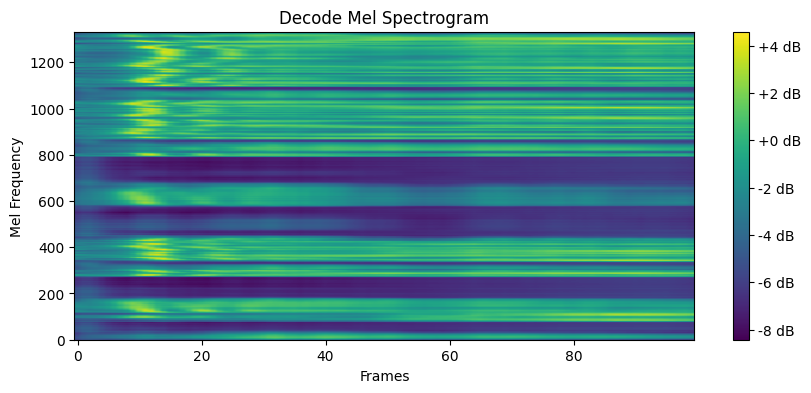

In [21]:
import numpy as np
def plot_mel(S,sr = 24000,title = "Mel Spectrogram"):
    # 使用matplotlib绘制Mel频谱图
    plt.figure(figsize=(10, 4))
    plt.imshow(S.T.to('cpu'), origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Frames')
    plt.ylabel('Mel Frequency')
    plt.show()
plot_mel(mel_spectrogram,title = "Origin Mel Spectrogram")
plot_mel(decoded_features[0], title= "Decode Mel Spectrogram")

In [22]:
import torch
from IPython.display import Audio

from vocos import Vocos

model = Vocos.from_hparams("/private/tmp/ChatTTS/config/vocos.yaml").to(device='cpu').eval()
model.load_state_dict(torch.load("/private/tmp/ChatTTS/asset/Vocos.pt"))

def mel_to_audio(mel_spectrogram):
    """将 Mel 频谱图转换回音频信号"""
    mel_spectrogram = mel_spectrogram.to(device='cpu')
    with torch.no_grad():
        audio = model.decode(mel_spectrogram[None])
    return audio.to('cpu').numpy()

播放原始音频和解压出来的音频

In [23]:
audio_waveform = mel_to_audio(mel_spectrogram)
Audio(audio_waveform,rate=24000)

播放生成的音频

In [24]:
audio_waveform = mel_to_audio(decoded_features[0])
Audio(audio_waveform,rate=24000)